In [1]:
# setup
import planet4 as p4
from planet4.dbscan import DBScanner
from planet4 import io, markings
import pandas as pd
from pathlib import Path
import pkg_resources as pr

with pr.resource_stream('planet4', 'data/test_db.csv') as f:
    data = pd.read_csv(f)

# import warnings
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore",category=DeprecationWarning)
    
from tempfile import TemporaryDirectory
import tempfile

_tdir = TemporaryDirectory()
tdir = Path(_tdir.name)

imid1 = 'APF000012w'
imid2 = 'APF000012q'

imid1data = data[data.image_id==imid1]
imid2data = data[data.image_id==imid2]

fans1 = imid1data[imid1data.marking=='fan']
blotches1 = imid1data[imid1data.marking=='blotch']
fans2 = imid2data[imid2data.marking=='fan']
blotches2 = imid2data[imid2data.marking=='blotch']

In [2]:
dbscanner = DBScanner(save_results=True)

In [9]:
from planet4 import region_data

In [10]:
region_data.Ithaca.season2

['ESP_011350_0945',
 'ESP_011351_0945',
 'ESP_011403_0945',
 'ESP_011404_0945',
 'ESP_011931_0945',
 'ESP_012063_0945',
 'ESP_012076_0945',
 'ESP_012643_0945',
 'ESP_012854_0945',
 'ESP_012858_0855']

In [11]:
obsid = region_data.Ithaca.season2[-1]
dbscanner.cluster_image_name(obsid)

APF0000bz8


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c10


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0z


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0e


Skipping due to lack of data.


APF0000bza


No clusters survived.
Skipping due to lack of data.


APF0000bzm


No clusters survived.


APF0000c03


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c15
APF0000c0q


No clusters survived.
No clusters survived.
Outdata was empty, nothing to store.


APF0000bzh


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0s


No clusters survived.


APF0000c0x


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0g


No clusters survived.


APF0000bzo


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0i


Skipping due to lack of data.


APF0000bze


Skipping due to lack of data.


APF0000bzg


No clusters survived.


APF0000c14


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c13


No clusters survived.
Skipping due to lack of data.


APF0000c01


Skipping due to lack of data.


APF0000bz7


Skipping due to lack of data.


APF0000bzq


Skipping due to lack of data.
Skipping due to lack of data.


APF0000bzt


Skipping due to lack of data.


APF0000c0a


Skipping due to lack of data.
Skipping due to lack of data.


APF0000bzj


Skipping due to lack of data.
No clusters survived.


APF0000c0r


Skipping due to lack of data.


APF0000c0u


No clusters survived.


APF0000bzs


Skipping due to lack of data.


APF0000c09


Skipping due to lack of data.


APF0000c0b


Skipping due to lack of data.
No clusters survived.
Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0j


Skipping due to lack of data.


APF0000c05


No clusters survived.
Skipping due to lack of data.
No clusters survived.


APF0000bzu
APF0000bzw


Skipping due to lack of data.


APF0000c0f


Skipping due to lack of data.
Skipping due to lack of data.
Skipping due to lack of data.


APF0000c04
APF0000bzv

Skipping due to lack of data.
Skipping due to lack of data.



APF0000bzz


Skipping due to lack of data.


APF0000bzp


Skipping due to lack of data.
Skipping due to lack of data.


APF0000bzb


No clusters survived.
No clusters survived.
No clusters survived.


APF0000bzf
APF0000c08


Skipping due to lack of data.


APF0000bzl


No clusters survived.
Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0t


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0h


Skipping due to lack of data.


APF0000bzi


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0o


Skipping due to lack of data.


APF0000c0w


No clusters survived.


APF0000bzn


Skipping due to lack of data.


APF0000c02


Skipping due to lack of data.


APF0000c06


Skipping due to lack of data.
Skipping due to lack of data.


APF0000bzy


Skipping due to lack of data.
No clusters survived.


APF0000bzc


Skipping due to lack of data.


APF0000c00


No clusters survived.
No clusters survived.


APF0000bz6


Skipping due to lack of data.


APF0000bzx


No clusters survived.
Skipping due to lack of data.


APF0000c11


Skipping due to lack of data.


APF0000bzd


Skipping due to lack of data.


APF0000c12


Skipping due to lack of data.


APF0000c0d


Skipping due to lack of data.
Skipping due to lack of data.


APF0000bz9


Skipping due to lack of data.


APF0000c0c


Skipping due to lack of data.


APF0000bzk


Skipping due to lack of data.


APF0000c0l


Skipping due to lack of data.


APF0000c07


Skipping due to lack of data.
Skipping due to lack of data.


APF0000bzr
APF0000c0k


Skipping due to lack of data.
No clusters survived.
No clusters survived.


APF0000c0p
APF0000c0y


No clusters survived.
Skipping due to lack of data.


APF0000c0m


Skipping due to lack of data.


APF0000c0v


Skipping due to lack of data.
Skipping due to lack of data.


APF0000c0n


In [5]:
db = io.DBManager()

In [6]:
data = db.get_image_name_markings(obsid)

In [7]:
data.shape

(0, 23)

In [8]:
db.dbname

'/Users/klay6683/Dropbox/data/planet4/2017-01-01_planet_four_classifications_queryable_cleaned_seasons2and3.h5'

In [123]:
dbscanner.eps_values

{'blotch': {'angle': 20,
  'radius': {'large': 50, 'small': 30},
  'xy': {'large': 50, 'small': 15}},
 'fan': {'angle': 20,
  'radius': {'large': None, 'small': None},
  'xy': {'large': 50, 'small': 10}}}

In [124]:
dbscanner.cluster_image_id('12w')

Skipping due to lack of data.


In [121]:
p4id = markings.ImageID('12w')

In [79]:
dbscanner.reduced_data['fan'].shape

(4, 15)

In [80]:
%matplotlib inline

No clusters survived.


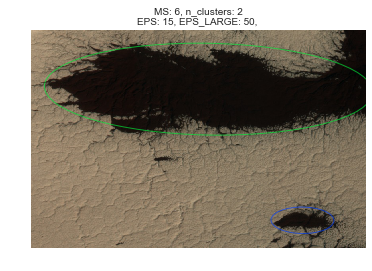

In [81]:
dbscanner.cluster_and_plot('17a', 'blotch')

No clusters survived.
No clusters survived.
No clusters survived.


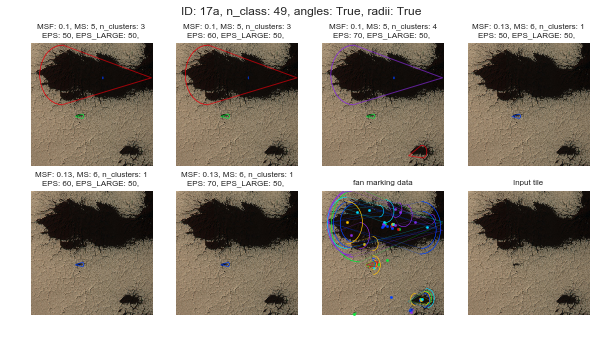

In [85]:
dbscanner.parameter_scan('17a', 'fan', [0.1, 0.13], [50, 60, 70], size_to_scan='small')

In [75]:
dbscanner.save_results

False

In [12]:
# test_calc_fnotch
actual = clustering.calc_fnotch(4, 4)
assert actual == 0.5
actual = clustering.calc_fnotch(4, 0)
assert actual == 1
actual = clustering.calc_fnotch(0, 4)
assert actual == 0

In [13]:
# test_dbscan_xy_blotch

# using only x and y (or image_x,image_y)
coords = ['image_x','image_y']
X = blotches1[coords].values
dbscanner = clustering.DBScanner(X, min_samples=2)

assert dbscanner.n_clusters == 26
assert dbscanner.n_rejected == 25

In [14]:
# test_dbscan_xy_fan

# using only x and y (or image_x,image_y)
coords = ['image_x','image_y']
X = fans1[coords].values
dbscanner = clustering.DBScanner(X, min_samples=2)

assert dbscanner.n_clusters == 7
assert dbscanner.n_rejected == 11

In [15]:
# test_dbscan_xy_angle_blotch

coords = ['image_x','image_y', 'angle']
X = blotches1[coords].values
dbscanner = clustering.DBScanner(X, min_samples=2)

assert dbscanner.n_clusters == 35
assert dbscanner.n_rejected == 102

In [16]:
# test_dbscan_xy_angle_fan

coords = ['image_x','image_y', 'angle']
X = fans1[coords].values
dbscanner = clustering.DBScanner(X, min_samples=2)

assert dbscanner.n_clusters == 6
assert dbscanner.n_rejected == 15

In [26]:
# test_clustering_basics

cm.cluster_image_id(imid1, data=imid1data)

assert cm.n_classifications == 28

In [30]:
cm.cluster_image_id(imid2, data=imid2data)
assert cm.n_classifications == 23

for subdir in ['just_clustering']:  # 'applied_cut_0.5', 
    expected = tdir / subdir
    assert expected.exists() and expected.is_dir()

In [29]:
# test_output_file_creation_just_clustering

for marking in ['blotches', 'fans']:
    expected = tdir / 'just_clustering' / (imid1 + '_' + marking + '.csv')
    print()
    assert expected.exists()

for marking in ['blotches']:
    expected = tdir / 'just_clustering' / (imid2 + '_' + marking + '.csv')
    if marking == 'blotches':
        assert expected.exists()
    else: # 12q,i.e. imdid2 only has blotches
        assert not expected.exists()

##  same user rejection

In [8]:
s = """
x	y	image_x	image_y	angle	spread	distance	user_name	marking	classification_id
67.0	320.0	67.0	27172.0	90.0	2.01745014480398	10.0	test_user	fan	50ec9c10861cf8095600017b
74.0	318.0	74.0	27170.0	90.0	2.01745014480398	10.0	test_user	fan	50ec9c10861cf8095600017b
82.0	336.0	82.0	27188.0	90.0	2.01745014480398	10.0	test_user	fan	50ec9c10861cf8095600017b
57.0	310.0	57.0	27162.0	90.0	2.01745014480398	10.0	test_user	fan	50ec9c10861cf8095600017b
60.0	315.0	60.0	27167.0	35.21759296819272	10.434250055350423	41.617304093369626	test_user	fan	50ec9c10861cf8095600017b
63.0	307.0	63.0	27159.0	62.38162109858792	2.01745014480398	437.89610639968015	test_user	fan	50ec9c10861cf8095600017b
"""

In [9]:
from io import StringIO

In [10]:
df = pd.read_table(StringIO(s))
df

,x,y,image_x,image_y,angle,spread,distance,user_name,marking,classification_id
0,67.0,320.0,67.0,27172.0,90.000000,2.01745,10.000000,test_user,fan,50ec9c10861cf8095600017b
1,74.0,318.0,74.0,27170.0,90.000000,2.01745,10.000000,test_user,fan,50ec9c10861cf8095600017b
2,82.0,336.0,82.0,27188.0,90.000000,2.01745,10.000000,test_user,fan,50ec9c10861cf8095600017b
3,57.0,310.0,57.0,27162.0,90.000000,2.01745,10.000000,test_user,fan,50ec9c10861cf8095600017b
4,60.0,315.0,60.0,27167.0,35.217593,10.43425,41.617304,test_user,fan,50ec9c10861cf8095600017b
5,63.0,307.0,63.0,27159.0,62.381621,2.01745,437.896106,test_user,fan,50ec9c10861cf8095600017b


In [15]:
cm.data = df
cm.pm.id_ = 'test_id'

In [16]:
cm.cluster_data()

In [25]:
cm.reduced_data['fan'][0]

markings.Fan object. Input data:
base: [  64.2  314. ]
armlength: 98.76505578182862
arm1: [  94.49183016  408.00500662]
arm2: [  88.36097632  409.76420765]

# some bug hunting

In [266]:
def hunt_bug(fname):
    df = pd.read_csv(fname)
    return (df[df.duplicated()].shape[0])

In [310]:
fnames = p.glob('*.csv')
obsids = []
no_of_dupes = []
kind = []
for fname in fnames:
    tokens = fname.name.split('_')
    if fname.name.startswith('ESP'):
        obsids.append('_'.join(tokens[:3]))
        kind.append(tokens[3].split('.')[0])
    else:
        obsids.append(tokens[0])
        kind.append(tokens[1].split('.')[0])
    no_of_dupes.append(hunt_bug(fname))

In [311]:
df = pd.DataFrame(dict(obsids=obsids, no_of_dupes=no_of_dupes,
                       kind=kind))
df

,kind,no_of_dupes,obsids
0,blotches,0,APF000012q
1,blotches,0,APF000012w
2,fans,0,APF000012w
3,blotches,0,APF0000ani
4,fans,0,APF0000ani
5,blotches,0,APF0000apx
6,fans,0,APF0000apx
7,blotches,0,ESP_011341_0980
8,fans,0,ESP_011341_0980
9,blotches,13,ESP_011350_0945


In [287]:
%matplotlib nbagg

In [322]:
db.get_image_id_markings('apx').iloc[0]

classification_id                                                    50ec0fd7a216840ccc0010fb
created_at                                                                2013-01-08 12:23:51
image_id                                                                           APF0000apx
image_name                                                                    ESP_011350_0945
image_url            http://www.planetfour.org/subjects/standard/50e7418f5e2ed21240003645.jpg
user_name                                                                             hsabido
marking                                                                                   fan
x_tile                                                                                      1
y_tile                                                                                     44
acquisition_date                                                          2008-12-27 00:00:00
local_mars_time                                             

In [323]:
db.get_image_id_markings('ani').iloc[0]

classification_id                                                    50ed6e5a60d405088c000086
created_at                                                                2013-01-09 13:19:22
image_id                                                                           APF0000ani
image_name                                                                    ESP_011350_0945
image_url            http://www.planetfour.org/subjects/standard/50e741865e2ed212400035ee.jpg
user_name                                                                            saqwedrf
marking                                                                                   fan
x_tile                                                                                      1
y_tile                                                                                     45
acquisition_date                                                          2008-12-27 00:00:00
local_mars_time                                             

<IPython.core.display.Javascript object>


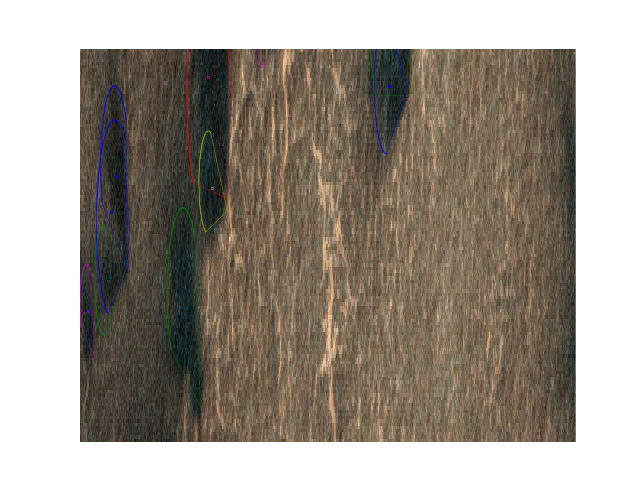

In [321]:
plotting.plot_clustered_fans('apx', _dir=tdir)

<IPython.core.display.Javascript object>


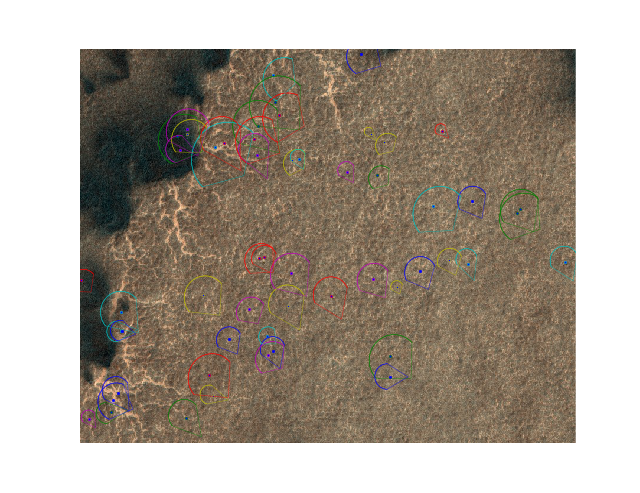

In [320]:
plotting.plot_clustered_fans('ani', _dir=tdir)

<IPython.core.display.Javascript object>


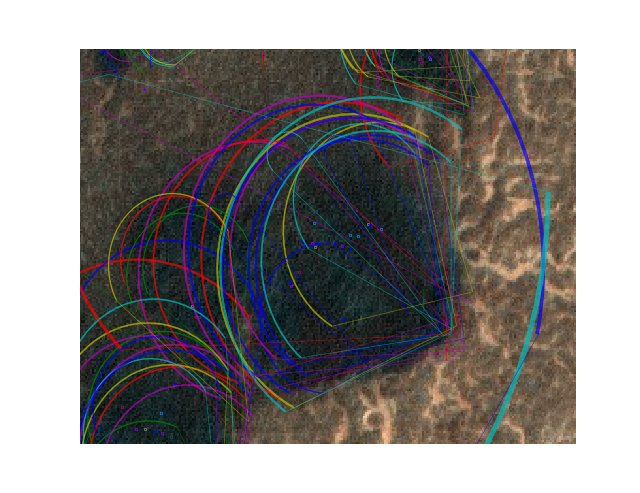

In [326]:
plotting.plot_raw_fans('ani')

In [315]:
newblotches = cm.newblotches.apply(lambda x: x.store())

In [316]:
newblotches[newblotches.duplicated(keep=False)].head()

,x,y,image_x,image_y,angle,radius_1,radius_2,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y,image_id,n_members
2,14.925927,550.555556,14.925927,24175.444444,58.840891,18.636164,17.160664,24.568584,24189.437672,5.283270,24161.451217,0.240968,24184.323654,29.610886,24166.565235,APF0000apx,1
3,14.925927,550.555556,14.925927,24175.444444,58.840891,18.636164,17.160664,24.568584,24189.437672,5.283270,24161.451217,0.240968,24184.323654,29.610886,24166.565235,APF0000apx,1
86,361.897361,514.560117,791.574780,26942.302053,66.637285,31.798333,26.446713,804.184427,26922.709660,778.965132,26961.894445,767.296357,26952.789512,815.853203,26931.814593,APF0000aok,1
87,361.897361,514.560117,791.574780,26942.302053,66.637285,31.798333,26.446713,804.184427,26922.709660,778.965132,26961.894445,767.296357,26952.789512,815.853203,26931.814593,APF0000aok,1
103,453.312500,209.375000,777.062500,29253.375000,68.836492,29.213663,22.066497,787.609529,29245.342460,766.515471,29261.407540,756.484301,29261.341683,797.640699,29245.408317,APF0000aqj,1


In [317]:
cm.pm.fnotchdf.head()

,fan_x,fan_y,fan_image_x,fan_image_y,fan_angle,fan_spread,fan_distance,fan_arm1_x,fan_arm1_y,fan_arm2_x,...,blotch_p1_y,blotch_p2_x,blotch_p2_y,blotch_p3_x,blotch_p3_y,blotch_p4_x,blotch_p4_y,blotch_image_id,blotch_n_members,fnotch_value
0,566.761111,157.116667,1306.761111,10496.050000,229.578482,86.728382,67.602026,1259.220770,10490.873469,1309.216104,...,10503.095239,1284.337131,10433.051103,1257.431664,10471.500211,1319.876373,10464.646131,APF0000anc,41,0.594059
1,779.875000,318.500000,779.875000,28814.500000,204.900243,77.357040,37.103297,754.238078,28820.786727,768.129429,...,28803.855480,754.531200,28807.001663,750.478234,28812.427636,777.664624,28798.429507,APF0000anj,7,0.363636
2,25.500000,512.800000,25.500000,24186.400000,235.234034,49.589307,33.124490,3.981659,24173.755375,21.178313,...,24189.437672,5.283270,24161.451217,0.240968,24184.323654,29.610886,24166.565235,APF0000apx,9,0.357143
3,26.250000,343.750000,26.250000,24181.750000,217.473561,82.348623,31.242248,4.155226,24183.179096,21.891816,...,24189.437672,5.283270,24161.451217,0.240968,24184.323654,29.610886,24166.565235,APF0000apx,9,0.307692
4,631.464286,298.214286,631.464286,23862.214286,230.531025,106.840345,80.255446,574.169660,23865.105827,645.295334,...,23854.442998,578.120691,23805.767528,570.478152,23849.300849,634.767463,23810.909678,APF0000apx,19,0.424242


In [318]:
cm.pm.fnotchdf.filter(regex='_image_id').head()

,fan_image_id,blotch_image_id
0,APF0000aqc,APF0000anc
1,APF0000apj,APF0000anj
2,APF0000apx,APF0000apx
3,APF0000ani,APF0000apx
4,APF0000apx,APF0000apx


In [319]:
cm.pm.fnotchdf.iloc[2:4].T

,2,3
fan_x,25.5,26.25
fan_y,512.8,343.75
fan_image_x,25.5,26.25
fan_image_y,24186.4,24181.8
fan_angle,235.234,217.474
fan_spread,49.5893,82.3486
fan_distance,33.1245,31.2422
fan_arm1_x,3.98166,4.15523
fan_arm1_y,24173.8,24183.2
fan_arm2_x,21.1783,21.8918


In [275]:
fn1 = markings.Fnotch.from_series(cm.pm.fnotchdf.iloc[2], scope='hirise')

In [276]:
fn2 = markings.Fnotch.from_series(cm.pm.fnotchdf.iloc[3], scope='hirise')

In [277]:
fn1.fan

base: [    25.5  24186.4]
armlength: 24.95847596971124
arm1: [  3.98165916e+00   2.41737554e+04]
arm2: [  2.11783133e+01   2.41618185e+04]

In [278]:
fn2.fan

base: [    26.25  24181.75]
armlength: 22.14094297763962
arm1: [  4.15522592e+00   2.41831791e+04]
arm2: [  2.18918161e+01   2.41600422e+04]

In [280]:
norm(fn1.fan.midpoint - fn2.fan.midpoint)

3.930315289014819

In [218]:
p4id = markings.ImageID('apx', data=data, scope='planet4')

In [212]:
%matplotlib inline

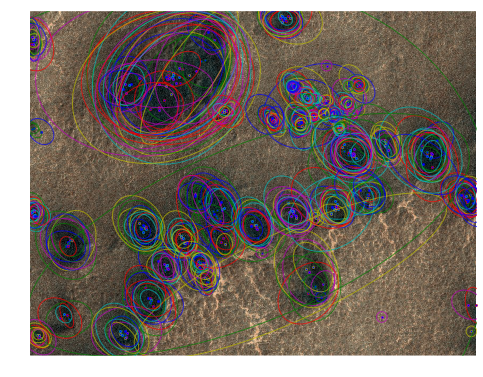

In [219]:
p4id.plot_blotches()

In [220]:
from planet4 import plotting

In [221]:
plotting.plot_clustered_blotches('apx', _dir=tdir)

Clustered blotchfile not found


In [230]:
pm = io.PathManager(id_='apx', datapath=tdir)

In [232]:
pm.reduced_blotchfile

PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/APF0000apx_blotches.csv')

In [233]:
tdir

PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b')

In [236]:
list(tdir.glob('just_clustering/*'))

[PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/APF000012q_blotches.csv'),
 PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/APF000012w_blotches.csv'),
 PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/APF000012w_fans.csv'),
 PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/ESP_011341_0980_blotches.csv'),
 PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/ESP_011341_0980_fans.csv'),
 PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/ESP_011350_0945_blotches.csv'),
 PosixPath('/var/folders/tt/k11390b92vl_dygt4m0s7gjr008bbb/T/tmpqjfg8j5b/just_clustering/ESP_011350_0945_fans.csv')]

In [80]:
newblotches = cm.newblotches.apply(lambda x: x.store())

In [81]:
newblotches.head()

,x,y,image_x,image_y,angle,radius_1,radius_2,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y,image_id,n_members
1,779.250000,427.300000,779.250000,7551.300000,20.230025,11.718488,11.278663,790.245598,438.806880,768.254402,415.793120,775.349952,437.882904,783.150048,416.717096,APF00006ol,1
2,779.250000,427.300000,779.250000,7551.300000,20.230025,11.718488,11.278663,790.245598,438.806880,768.254402,415.793120,775.349952,437.882904,783.150048,416.717096,APF00006ol,1
4,779.250000,427.300000,779.250000,7551.300000,20.230025,11.718488,11.278663,790.245598,438.806880,768.254402,415.793120,775.349952,437.882904,783.150048,416.717096,APF00006ol,1
5,779.250000,427.300000,779.250000,7551.300000,20.230025,11.718488,11.278663,790.245598,438.806880,768.254402,415.793120,775.349952,437.882904,783.150048,416.717096,APF00006ol,1
6,522.358427,420.613676,522.358427,7544.613676,23.174511,11.012768,10.390235,532.482580,410.417157,512.234274,430.810196,518.269527,430.165528,526.447327,411.061824,APF00006ol,1


In [92]:
b1 = markings.Blotch(cm.newblotches.iloc[0].data)
b2 = markings.Blotch(cm.newblotches.iloc[1].data)
b1 == b2

True

In [93]:
df = cm.pm.fnotchdf

In [146]:
df.apply?

In [95]:
df.duplicated().value_counts()

False    9479
dtype: int64

In [96]:
final_clusters = df.apply(markings.Fnotch.from_series, axis=1).apply(lambda x: x.get_marking(0.5))

In [118]:
pd.set_option('display.width', 10000)

In [114]:
final_clusters.head()

0    base: [ 795.49523722  441.97142893]\narmlength: 37.35593360580642\narm1: [ 758.19761962  444.057...
1    markings.Blotch object. Input data:\nx                779.25\ny                 427.3\nimage_x  ...
2    markings.Blotch object. Input data:\nx                779.25\ny                 427.3\nimage_x  ...
3    base: [ 794.14285714  430.57142857]\narmlength: 26.4938909332825\narm1: [ 767.65091333  430.8926...
4    markings.Blotch object. Input data:\nx                779.25\ny                 427.3\nimage_x  ...
dtype: object

In [120]:
df.filter(regex='fan_').head()

,fan_x,fan_y,fan_image_x,fan_image_y,fan_angle,fan_spread,fan_distance,fan_arm1_x,fan_arm1_y,fan_arm2_x,fan_arm2_y,fan_image_id,fan_n_members
0,795.495237,441.971429,795.495237,32225.971429,203.941285,54.286376,50.284261,758.197620,444.057932,772.029213,412.905788,APF00006mu,15
1,792.833333,433.333333,792.833333,7557.333333,198.530257,20.365076,30.160731,767.131091,429.561917,770.050084,420.853255,APF00006ol,3
2,794.166667,430.333333,794.166667,40069.000000,209.403708,37.561116,28.424126,772.146570,426.203175,779.229033,413.635730,APF00006my,3
3,794.142857,430.571429,794.142857,33467.142857,210.944544,63.278381,36.453917,767.650913,430.892629,781.943697,407.053207,APF00006ml,14
4,793.000000,430.458333,793.000000,42626.458333,209.427061,73.149611,34.384455,768.612276,433.516625,783.003659,408.004216,APF00006nz,4


In [121]:
df.filter(regex='blotch_').head()

,blotch_x,blotch_y,blotch_image_x,blotch_image_y,blotch_angle,blotch_radius_1,blotch_radius_2,blotch_p1_x,blotch_p1_y,blotch_p2_x,blotch_p2_y,blotch_p3_x,blotch_p3_y,blotch_p4_x,blotch_p4_y,blotch_image_id,blotch_n_members
0,779.25,427.3,779.25,7551.3,20.230025,11.718488,11.278663,790.245598,438.80688,768.254402,415.79312,775.349952,437.882904,783.150048,416.717096,APF00006ol,10
1,779.25,427.3,779.25,7551.3,20.230025,11.718488,11.278663,790.245598,438.80688,768.254402,415.79312,775.349952,437.882904,783.150048,416.717096,APF00006ol,10
2,779.25,427.3,779.25,7551.3,20.230025,11.718488,11.278663,790.245598,438.80688,768.254402,415.79312,775.349952,437.882904,783.150048,416.717096,APF00006ol,10
3,779.25,427.3,779.25,7551.3,20.230025,11.718488,11.278663,790.245598,438.80688,768.254402,415.79312,775.349952,437.882904,783.150048,416.717096,APF00006ol,10
4,779.25,427.3,779.25,7551.3,20.230025,11.718488,11.278663,790.245598,438.80688,768.254402,415.79312,775.349952,437.882904,783.150048,416.717096,APF00006ol,10


In [130]:
from planet4 import markings

In [136]:
fnotch = markings.Fnotch.from_series(df.iloc[0], scope='planet4')

In [137]:
from numpy.linalg import norm

In [138]:
norm(fnotch.blotch.center - fnotch.fan.midpoint)

9.3489380070626815

In [89]:
def filter_for_fans(x):
            if isinstance(x, markings.Fan):
                return x

def filter_for_blotches(x):
    if isinstance(x, markings.Blotch):
        return x

In [91]:
final_clusters.apply(filter_for_blotches)

0    None
dtype: object

In [97]:
pd.read_csv(cm.pm.final_fanfile).duplicated().value_counts()

False    5
dtype: int64

In [32]:
# teardown
_tdir.cleanup()